# Overfit Complexity - K Nearest Neighbors
- Supervised 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
from sklearn import datasets, preprocessing
from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix

In [2]:

# Function to visualize a data set in 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Function to display the decision surface of a classifier
def plot_decision_region(X, pred_fun):
    print(X.shape)
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

A classification model can be so complex as to memorize the training set. This complexity is determined by the internal parameters of the model. Next, we will see how this complexity behaves using a non-linear classification model such as *k-nearest neighbors*.

## Dataset definition

We are going to work with an artificial dataset. The set is created using the Scikit-Learn `make_moons` functionality. `make_moons` allows you to introduce some noise into the created samples.

In [3]:
X, y = make_moons(n_samples=600, noise=0.3, random_state=0)

In [4]:
print ('X ~ n_samples x n_characteristics:', X.shape)
print ('y ~ n_samples:', y.shape)

print ('\nFirst 5 samples: \n', X [: 5,:])
print ('\nFirst 5 tags:', y[: 5])

X ~ n_samples x n_characteristics: (600, 2)
y ~ n_samples: (600,)

First 5 samples: 
 [[ 0.70558369 -0.57087449]
 [ 0.17553063  1.0055569 ]
 [-0.5316905   0.81385807]
 [ 1.075774   -0.88368429]
 [-0.14128686  0.62790384]]

First 5 tags: [1 0 0 1 0]


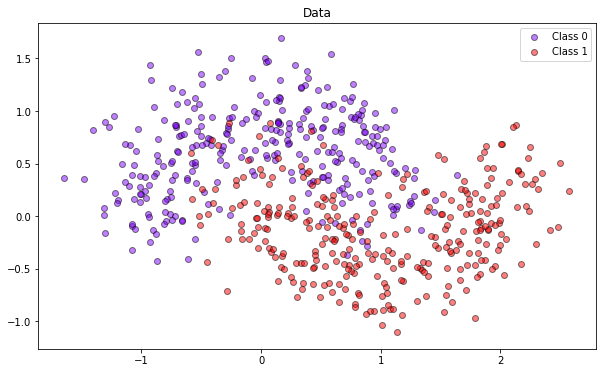

In [5]:
pl.figure(figsize = (10, 6))  
plot_data(X, y)

We observe that it is difficult to establish a linear separation, such as that obtained with logistic regression:

(600, 2)
Score: 0.8666666666666667


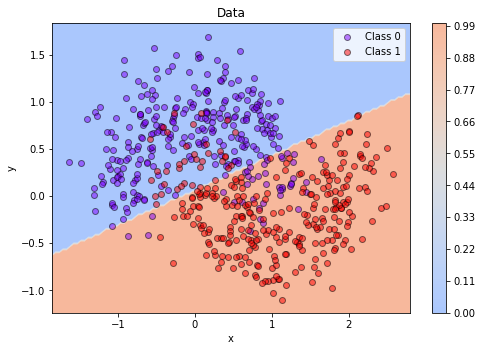

In [6]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs');
lr_model.fit(X, y)
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, gen_pred_fun(lr_model))
plot_data(X, y)
print("Score:",lr_model.score(X, y))

Therefore it is necessary to use a nonlinear classification model.

# Algorithm: K-Nearest Neighbors

Neighbor-based classification is a type of example-based learning. The model stores the examples seen during training and classifies an unseen item, using a simple majority voting rule. If a **point** is located in the characteristics space, it is assigned as a class the value of the class that has the most examples in the vicinity of the point. This example can be seen illustrated in the image:

<img src = "https://drive.google.com/uc?export=view&id=10I5967XssKpLQLivqER1uwfEw9qIsARd">

Scikit-Learn provides an implementation of the algorithm known as `KNeighborsClassifier`. `KNeighborsClassifier` has a parameter $ n\_neighbors $ or $ k $, where $ k $ is a user-defined integer that determines how many neighbors it evaluates to determine the class of an instance never seen before. The choice of this parameter is totally defined by the nature of the data.

We will observe that depending on the value of closest neighbors, we get different adjustment functions, some smoother than others. We will evaluate the effect of the parameter $ k $ on the complexity of the model.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
knn = KNeighborsClassifier(n_neighbors=1)

We are going to extract a random percentage from the data set.

In [9]:
idx = np.random.choice(len(X), int(len(X)*.5), replace=False)
X_reduced = X[idx]
y_reduced = y[idx]
print(X_reduced.shape)

(300, 2)


We train a `knn` model by calling the `fit ()` function on the reduced dataset

In [10]:
knn.fit(X_reduced, y_reduced)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

(300, 2)


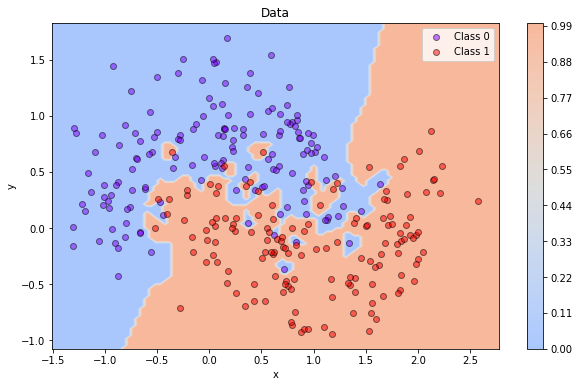

In [11]:
pl.figure(figsize = (10, 6))
plot_decision_region(X_reduced, gen_pred_fun(knn))
plot_data(X_reduced, y_reduced)

In [12]:
print('Error: {}'.format(1 - knn.score(X_reduced, y_reduced)))

Error: 0.0


**Does it make sense that the error is $ 0 \% $?**

Now let's add the data that we discarded previously


(300, 2)


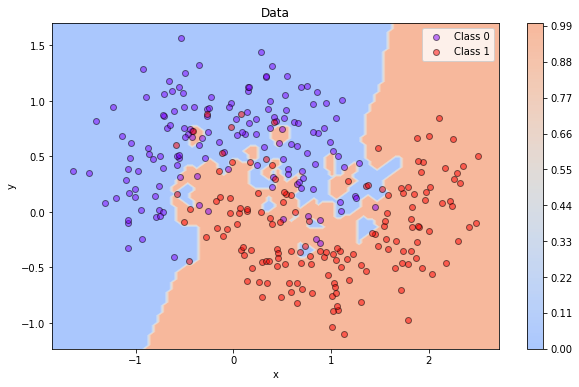

In [13]:
idx_c = [i for i in range(len(X)) if i not in idx]
X_complement = X[idx_c]
y_complement = y[idx_c]

pl.figure(figsize = (10, 6))   
plot_decision_region(X_complement, gen_pred_fun(knn))
plot_data(X_complement, y_complement)

In [14]:
print('Error: {}'.format(1 - knn.score(X_complement, y_complement)))

Error: 0.11333333333333329


We can see that when the number of neighbors is $ 1 $, the model adjusts too much to the noise of the input data, therefore it suffers from **overfitting**.

# Training error and generalization

A machine learning model's main objective is to make accurate predictions about examples never seen before by the model. This is known as a generalization error. In order to measure the generalization error, we divide the dataset into two partitions:

* **Training **: It will be used to train the model.
* **Test **: It will be used to measure the generalization error.

In the following image we find an illustration of how a partitioning is done in training and testing.

<img src = "https://drive.google.com/uc?export=view&id=1wTnv5b52qkLDhgkBgHvA6zs_BEW9a44R">

One of the recommended practices is to partition the data $ 70\% $ for training and $ 30\% $ for testing. When the number of samples is very large ($ \ge 70K $), we can reduce the percentage of samples for testing, to $ 90-10\% $. However, some clarifications should be made about generalization:

* The test set must be a representative sample of the data set. Sample sampling should be done independently and identically randomly from a distribution. This means that the sampling of one example is not influenced by the sampling of another.
* Distribution is stationary. In other words, it does not change throughout the data set.
* The examples are sampled from partitions of the same distribution. That is, no new features should be created on the test partition.

Additionally, we must take into account that the distribution of the data labels is preserved both in training and in testing (stratification). Scikit-Learn allows us to partition a data set in training and testing. Next, we are going to divide the set into $ 70\% $ for training and $ 30\% $ for testing.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

#### Parameters:

* `test_size`: Size of the test partition
* `random_state`: Seed of the pseudorandom number generator. This parameter guarantees reproducibility of partitioning.
* `stratify`: If the data is stratified with respect to `y`

We are going to verify the number of samples of both partitions and the class distribution of each one.

In [16]:
print ('Number of samples in training: {}'. format (X_train.shape [0]))
print ('Number of samples under test: {}'. format (X_test.shape [0]))
print ('Number of features: {}'. format (X_train.shape [1]))

print ('Distribution of classes in training: {}'. format (np.bincount (y_train)))
print ('Distribution of classes in test: {}'. format (np.bincount (y_test)))

Number of samples in training: 420
Number of samples under test: 180
Number of features: 2
Distribution of classes in training: [210 210]
Distribution of classes in test: [90 90]


We use the newly created partition and analyze a trained model with $ k = 200 $.

In [17]:
knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=200, p=2,
                     weights='uniform')

(420, 2)


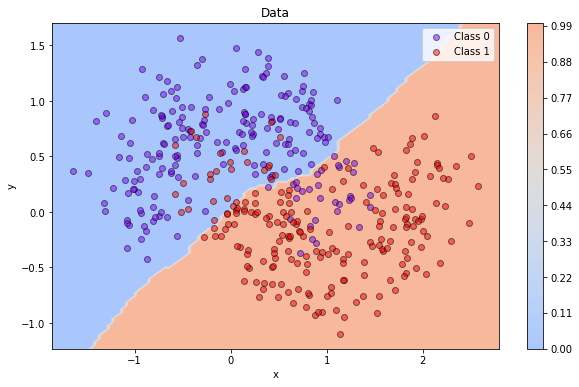

In [18]:
pl.figure(figsize = (10, 6)) 
plot_decision_region(X_train, gen_pred_fun(knn))
plot_data(X_train, y_train)

In [19]:
print ('Training error: {}'. format (1-knn.score (X_train, y_train)))

Training error: 0.14761904761904765


We note that the training error is $ 14 \% $. Furthermore, it is evident that the trained model is now too **simple** and cannot be adjusted to the structure of the data.


Now we measure the generalization error of the trained model and visualize the classification of the test data.

(180, 2)


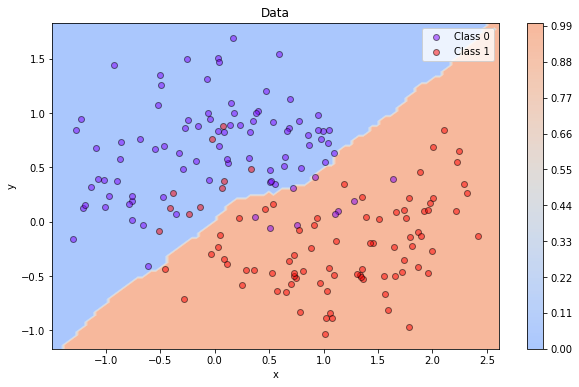

In [20]:
pl.figure(figsize = (10, 6))   
plot_decision_region(X_test, gen_pred_fun(knn))
plot_data(X_test, y_test)

In [21]:
print ('Generalization error: {}'. format (1 - knn.score (X_test, y_test)))

Generalization error: 0.10555555555555551


We can see that when we increase the number of neighbors, our model suffers from **sub-adjustment**. The decision surface is smoothed, but fails to capture the details of the data. As the training error approaches $ 14 \% $, the generalization error approaches $ 10 \% $.

**How to estimate a good number of nearest $ k $ -neighbors so that the model does not overfit or underfit the data?**

# Assessment of complexity

A machine learning model can be so complex as to remember the particularities and noise of the training set (**overfit**), as well as being too flexible not to model the variability of the data (**underfit** ). The model must ensure a compromise between overfitting and underfitting, which is accomplished by evaluating the complexity of the model. One way to assess complexity is to analyze training error and generalization for different models that vary in complexity. In the case of `KNearestNeighbour`, the complexity is determined by the number of neighbors $ k $. **The smaller the number of neighbors, the more complex the model is.**

Next, we explore a set of values $ k $, with the aim of finding the model with the best compromise between training error and generalization error.

In [22]:
k_values = list(range(1, 200))
print(k_values)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


We are going to generate a new dataset with $ 1000 $ samples and make a partition $ 70-30 $.

In [23]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

We evaluate training and generalization error for different complexity values of the model:

In [24]:
train_error = []
generalization_error = []

for nn in k_values:
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn.fit(X_train, y_train)
    train_error.append(1 - knn.score(X_train, y_train))
    generalization_error.append(1 - knn.score(X_test, y_test))

We visualize both learning curves.

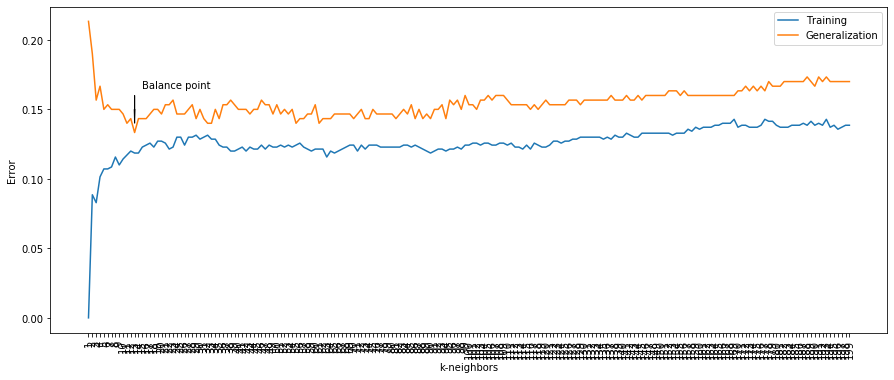

In [25]:
pl.figure(figsize = (15, 6))

pl.plot(k_values, train_error, label="Training")
pl.plot(k_values, generalization_error, label="Generalization")
pl.xticks(k_values, rotation=90)
pl.xlabel("k-neighbors")
pl.ylabel("Error")
#pl.gca().invert_xaxis()
pl.arrow(13, 0.16, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(15, 0.165, 'Balance point')
pl.legend();

It is observed that the training error is higher for simpler models (high k value) and tends to zero for more complex models (low k value). We find that the validation error is high at both ends, and has its minimum balance point at $ k = $ 13.

In [26]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

(700, 2)


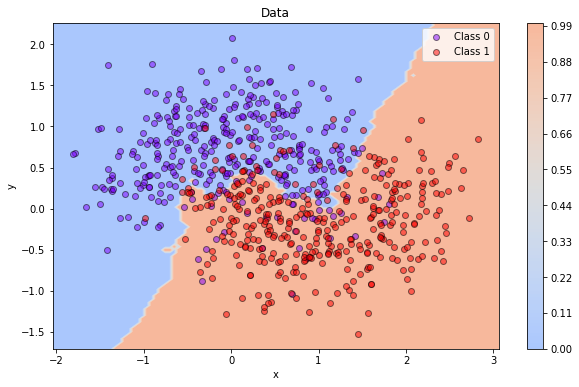

In [27]:
pl.figure(figsize = (10, 6)) 
plot_decision_region(X_train, gen_pred_fun(knn))
plot_data(X_train, y_train)

In [28]:
print ('Training error: {}'. format (1-knn.score (X_train, y_train)))

Training error: 0.11857142857142855


(300, 2)


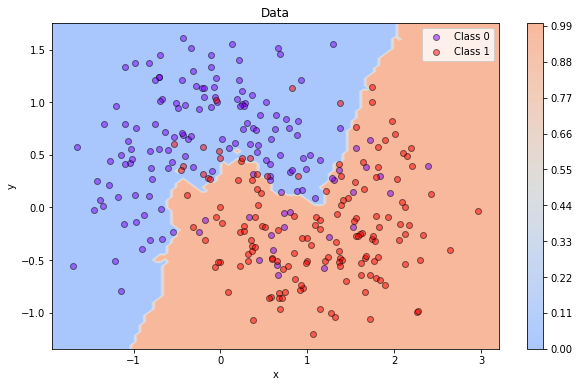

In [29]:
pl.figure(figsize = (10, 6))   
plot_decision_region(X_test, gen_pred_fun(knn))
plot_data(X_test, y_test)

In [30]:
print ('Generalization error: {}'. format (1 - knn.score (X_test, y_test)))

Generalization error: 0.1333333333333333


# Other Example

In [31]:
df = pd.read_csv('../Datasets/Week8/teleCust1000t.csv')
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


In [32]:
df['custcat'].value_counts()

3    281
1    266
4    236
2    217
Name: custcat, dtype: int64

#### 281 Plus Service, 266 Basic-service, 236 Total Service, and 217 E-Service customers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025854316088>]],
      dtype=object)

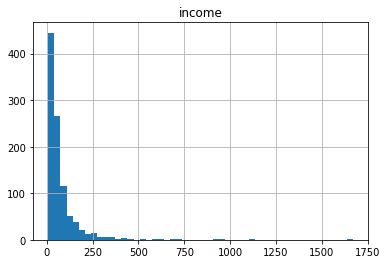

In [33]:
df.hist(column='income', bins=50)

In [34]:
df.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

In [35]:
X = df[['region', 'tenure','age', 'marital', 'address', 'income', 'ed', 'employ','retire', 'gender', 'reside']] .values  #.astype(float)
X[0:5]

array([[  2.,  13.,  44.,   1.,   9.,  64.,   4.,   5.,   0.,   0.,   2.],
       [  3.,  11.,  33.,   1.,   7., 136.,   5.,   5.,   0.,   0.,   6.],
       [  3.,  68.,  52.,   1.,  24., 116.,   1.,  29.,   0.,   1.,   2.],
       [  2.,  33.,  33.,   0.,  12.,  33.,   2.,   0.,   0.,   1.,   1.],
       [  2.,  23.,  30.,   1.,   9.,  30.,   1.,   2.,   0.,   0.,   4.]])

In [36]:
y = df['custcat'].values
y[0:5]

array([1, 4, 3, 1, 3], dtype=int64)

## Normalize Data 

In [37]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.02696767, -1.055125  ,  0.18450456,  1.0100505 , -0.25303431,
        -0.12650641,  1.0877526 , -0.5941226 , -0.22207644, -1.03459817,
        -0.23065004],
       [ 1.19883553, -1.14880563, -0.69181243,  1.0100505 , -0.4514148 ,
         0.54644972,  1.9062271 , -0.5941226 , -0.22207644, -1.03459817,
         2.55666158],
       [ 1.19883553,  1.52109247,  0.82182601,  1.0100505 ,  1.23481934,
         0.35951747, -1.36767088,  1.78752803, -0.22207644,  0.96655883,
        -0.23065004],
       [-0.02696767, -0.11831864, -0.69181243, -0.9900495 ,  0.04453642,
        -0.41625141, -0.54919639, -1.09029981, -0.22207644,  0.96655883,
        -0.92747794],
       [-0.02696767, -0.58672182, -0.93080797,  1.0100505 , -0.25303431,
        -0.44429125, -1.36767088, -0.89182893, -0.22207644, -1.03459817,
         1.16300577]])

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (800, 11) (800,)
Test set: (200, 11) (200,)


In [39]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [40]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([1, 1, 3, 2, 4], dtype=int64)

In [41]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.5475
Test set Accuracy:  0.32


In [42]:
k = 6
neigh6 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat6 = neigh6.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh6.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat6))


Train set Accuracy:  0.51625
Test set Accuracy:  0.31


In [43]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.3  , 0.29 , 0.315, 0.32 , 0.315, 0.31 , 0.335, 0.325, 0.34 ])

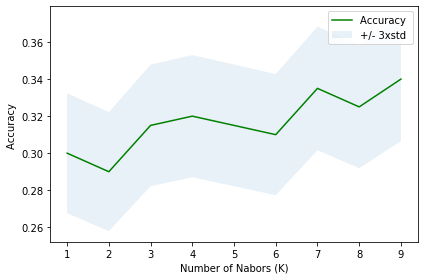

In [44]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [45]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.34 with k= 9


In [46]:
k = 9
neigh9 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat9 = neigh6.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh9.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat9))


Train set Accuracy:  0.5025
Test set Accuracy:  0.31


# Other Datasets

We will use Breast Cancer

 # Data
malignant = 0 and benign = 1

In [47]:
from sklearn.datasets import load_breast_cancer

In [48]:
breast_cancer = load_breast_cancer()
df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
X = df[['mean area', 'mean compactness']]
y = pd.Categorical.from_codes(breast_cancer.target, breast_cancer.target_names)
y = pd.get_dummies(y, drop_first=True)

In [49]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [50]:
y

,benign
0,0
1,0
2,0
3,0
4,0
...,...
564,0
565,0
566,0
567,0


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #random_state = 1

In [52]:
knn = KNeighborsClassifier(n_neighbors=5,metric='euclidean')
knn.fit(X_train, y_train)

C:\Users\TheGlitchCat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [53]:
y_pred = knn.predict(X_test)

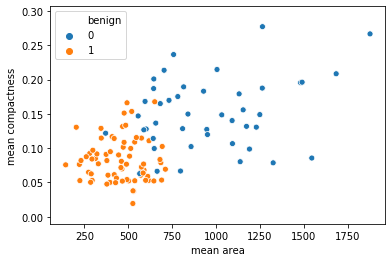

In [54]:
sns.scatterplot(
    x='mean area',
    y='mean compactness',
    hue='benign',
    data=X_test.join(y_test, how='outer')
)

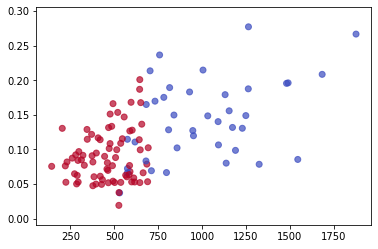

In [55]:
plt.scatter(
    X_test['mean area'],
    X_test['mean compactness'],
    c=y_pred,
    cmap='coolwarm',
    alpha=0.7
)

In [56]:
confusion_matrix(y_test, y_pred)

array([[32, 12],
       [ 7, 63]], dtype=int64)

In [57]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Train set Accuracy:  0.9032967032967033
Test set Accuracy:  0.8333333333333334


In [58]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77        44
           1       0.84      0.90      0.87        70

    accuracy                           0.83       114
   macro avg       0.83      0.81      0.82       114
weighted avg       0.83      0.83      0.83       114



In [59]:
iris = datasets.load_iris()
cols = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width']

df = pd.DataFrame(iris.data, columns=cols)

In [60]:
df.head()

,sepal-length,sepal-width,petal-length,petal-width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [61]:
X = df.iloc[:, :].values
y = iris.target

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [65]:
y_pred = classifier.predict(X_test)

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[14  0  0]
 [ 0  8  0]
 [ 0  0  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [67]:
error = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

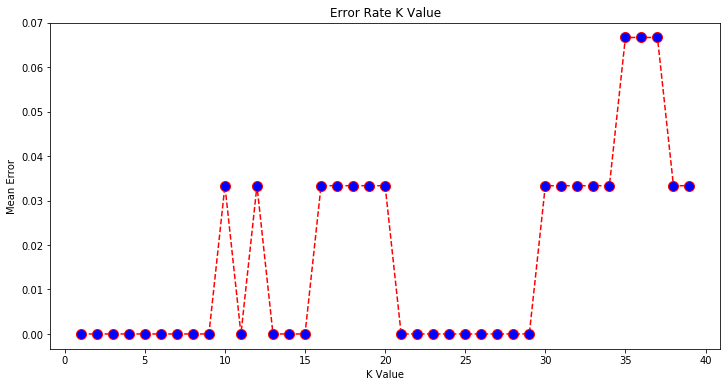

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [69]:
classifier = KNeighborsClassifier(n_neighbors=20)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[14  0  0]
 [ 0  8  0]
 [ 0  1  7]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.89      1.00      0.94         8
           2       1.00      0.88      0.93         8

    accuracy                           0.97        30
   macro avg       0.96      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30



In [70]:
import random
random.seed(0)

In [71]:

new_values = []

for i in range(0,20):
    aux = [random.uniform(4,5),random.uniform(3,4),random.uniform(1,2), random.uniform(0.2,0.8)]
    new_values.append(aux)

In [72]:
scaler.fit(new_values)
new_values = scaler.transform(new_values)

In [73]:
new_values

array([[ 1.28788904,  0.54135121, -0.98295536, -0.88316883],
       [ 0.0769736 , -0.89485198,  0.59024293, -0.71739353],
       [-0.04907234, -0.1688669 ,  1.1286694 ,  0.03454076],
       [-0.75697822,  0.53260349, -0.12626093, -0.91457344],
       [ 1.52532867,  1.45603836,  0.7046666 ,  1.5187342 ],
       [-0.65407869,  0.42693895,  1.08849953,  0.70403898],
       [-0.0652625 , -2.13257214, -0.92405033,  0.43109374],
       [ 1.53719548,  1.3902164 , -0.73851188,  1.38111321],
       [-0.83456447,  0.73286146, -0.42801228, -1.79753627],
       [ 0.83456999, -0.9197119 ,  0.76802185,  0.64492677],
       [-1.77724197, -0.53421997,  0.95321319, -0.93920101],
       [-0.59935061,  0.99910688, -1.97697854,  0.26912617],
       [-0.91408024,  1.39401574,  0.67418483, -0.17724251],
       [-1.48899327, -1.24016999, -0.60454501,  1.63324854],
       [-1.38499494, -0.2995205 ,  0.2557155 ,  0.1941851 ],
       [ 1.17900935, -0.34420558,  1.37002677,  0.40233679],
       [ 0.35446097, -0.

In [74]:
new_test = y_test[10:]

In [75]:
y_pred = classifier.predict(new_values)

In [76]:
print(confusion_matrix(new_test, y_pred))
print(classification_report(new_test, y_pred))

[[2 5 3]
 [0 3 1]
 [2 3 1]]
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        10
           1       0.27      0.75      0.40         4
           2       0.20      0.17      0.18         6

    accuracy                           0.30        20
   macro avg       0.32      0.37      0.29        20
weighted avg       0.36      0.30      0.28        20

